In this tutorial we will learn how to perform static (free energy Hessian) and dynamic (spectral function) SSCHA phonon calculations. We will perform the calculations on PbTe in the rock-salt structure ([Ribeiro et al.,Phys. Rev. B 97, 014306](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.97.014306)) and, in order to speed-up the calculation, we will emply a force-field model based on the work of [Ai at al, Phys. Rev. B 90, 014308](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.90.014308). The force-field model can be downloaded and installed from [here](https://github.com/mesonepigreco/F3ToyModel). The material to run the example (dynamical matrices and path file) can be downloaded from [here](https://). Unless otherwise specified, the equations and the sections we will refer to are in the paper [name_paper](https://) describing the SSCHA program.


We will work with a 4x4x4 supercell. To set up the interatomic force-field, we use the 8 (number of irreducible points in the 4x4x4 grid) matrices PbTe.ff.4x4x4.dyn#q to set up the interaction at harmonic level (obtained from first-principles), and we fix the parameters $p_3$, $p_4$ and $p_{4\chi}$ to set up the 3rd and 4th order anharmonic interaction. 

We perform the minimization of the free energy functional with respect to the effective harmonic matrices (the atomic positions are fixed in the high-symmetry $Fm\bar{3}m$ rock-salt configuration) at $300~\mathrm{K}$. As we have learnt in previous tutorials, in order to obtain the final SSCHA dynamical matrices we need to perform the minimization in several steps, generating different populations. With this script we generate, from the temporary SSCHA dynamical matrices obtained at the end of a minimization, the next ensamble (a.k.a. population) to continue the minimization and we also compute the energy-forces for elements of this ensamble. The dynamical matrices to be used to generate the first ensamble can be the same dynamical matrices that define the toy-model harmonic force field. The parameters to be inserted in this script are: the population number that is going to be generated ("population", integer), and the number of elements in this ensamble (" n_random", integer).

In [ ]:
from __future__ import print_function

# Import the cellconstructor stuff
import cellconstructor as CC
import cellconstructor.Phonons

# Import the modules of the force field
import fforces as ff
import fforces.Calculator

# Import the modules to run the sscha
import sscha, sscha.Ensemble, sscha.SchaMinimizer
import sscha.Relax, sscha.Utilities


# Import Matplotlib to plot
import numpy as np
import matplotlib.pyplot as plt



# ========================= TOY MODEL DEFINITION ===========================
# Dynamical matrices that set up the harmonic part of the force-field
ff_dyn_name="PbTe.ff.4x4x4.dyn"
# Paramters that set up the anharmonic part of the force-field
p3 = -0.0140806002
p4 = -0.01089564958
p4x = 0.00254038964
# ====================================================================

# ======================== TO BE SET ================================
# population to be generated (integer number)
population=  
# dynamical matrices to be used to generate the population
dyn_sscha_name="PbTe.dyn"
# temperature
T=300.
# number of ensamble elements
n_random=
# dir where the population ensamble is stored
ens_savedir="ens_pop"+str(population)
# ====================================================================


INFO = """
We compute the population #{} for PbTe with the force-field defined by 
the harmonic matrices: {} 
and the parameters:
p3=  {}
p4=  {}
p4x= {}

The ensamble will be generated from dyn mat: {}
The temperature is {} K
The number of ensamble elements is {}.
The ensamble with energy/forces will be saved in: {}

""".format(population,ff_dyn_name,p3,p4,p4x,dyn_sscha_name,T,n_random,ens_savedir)


print(INFO)
print()
print(" ======== RUNNING ======== ")
print()


# Setup the harmonic part of the force-field 
ff_dynmat = CC.Phonons.Phonons(ff_dyn_name, 8)
ff_calculator = ff.Calculator.ToyModelCalculator(ff_dynmat)
# Setup the anharmonic part of the force-field
ff_calculator.type_cal = "pbtex"
ff_calculator.p3 = p3
ff_calculator.p4 = p4
ff_calculator.p4x = p4x
# Load matrices
dyn_sscha=CC.Phonons.Phonons( dyn_sscha_name,8)
# Generate the ensemble
supercell=dyn_sscha.GetSupercell()
ens = sscha.Ensemble.Ensemble(dyn_sscha, T, supercell)
ens.generate(n_random)
# Compute energy and forces for the ensemble elements
ens.get_energy_forces(ff_calculator , compute_stress = False)
# save population
ens.save(ens_savedir, population)

Once the population ensamble has been generated, the minimization has to be performed. The input file to perform the minimization is

In [ ]:
cat > input << EOF
&inputscha
    n_random =                                ! number of elements (integer)
    data_dir = "ens_pop#(population-number)"  ! population directory path (character)                     
    population = 1                            ! population number (integer)
    fildyn_prefix = "PbTe.dyn"                ! dyn mat that generated the population (character)
    nqirr = 8
    supercell_size =  4 4 4
    Tg = 300.0 
    T  = 300.0
    preconditioning = .true.
    root_representation = "normal"
    meaningful_factor = 1e-12
    gradi_op = "gc" 
    n_random_eff =                            ! Kong-Liu parameter minimum threshold
    minim_struc  =  .false. 
    print_stress = .false.
    eq_energy = 0.0
    lambda_a = 0.1
    lambda_w = 0.1
    max_ka = 10000
/
&utils
    save_freq_filename = "Frequencies.dat"
&end
EOF

and it is launched with:

$: sscha -i input --save-data data_saved > output

At the end of the minimizations, performed with several populations, we have:

The dynamical matrices that generated the last population #popnum

PbTe.dyn#q

The last population, stored in the folder

ens_pop#popnum

The SSCHA dynamical matrices obtained with the last minimization

PbTe.SSCHA.dyn#q

We have all the ingredients to perform the next step and calculate the free energy Hessian (including or not the 4th order SSCHA FCs terms).

At the end of the calculation we will have two main results

1. The free energy Hessian dynamical matrices:

   PbTe.Hessian.dyn#q


2. The third order SSCHA FCs (conveniently symmetrized), 
   crucial for the spectral analysis that we will perform:
   
   d3_realspace_sym.npy

This is the script to perform such a calculation, where the parameters to be inserted are: the ensamble data directory ("DATA_DIR",string), and the number of elements in the ensamble ("N_RANDOM",integer), whereas ("INCLUDE_V4", logical) can be left as False (we will use functionalities that use only the third order FCs, i.e. the ''bubble''):

In [ ]:
from __future__ import print_function
from __future__ import division

# Import the modules to read the dynamical matrix
import cellconstructor as CC
import cellconstructor.Phonons

# Import the SCHA modules
import sscha, sscha.Ensemble


# Here the input information
DATA_DIR = # path to the directory ens_pop#lastpop where the last population is stored
N_RANDOM = # number elements in the ensamble
DYN_PREFIX =  'PbTe.dyn'  # dyn mat that generated the last population
FINAL_DYN =   'PbTe.SSCHA.dyn'    # SSCHA dyn mat obtained with the last minimization 
SAVE_PREFIX = 'PbTe.Hessian.dyn'  # Free energy Hessian dynamical matrices
NQIRR = 8
Tg = 300
T =  300
POPULATION = # number of last population
INCLUDE_V4 = False # True to include the 4th-order SSCHA FC term to calculate the Hessian 

INFO = """
In this example we compute the free energy hessian.

The ensemble has been generated with the dynamical matrix at:
{}

And to compute the hessian we will use reweighting at:
{}

The original temperature was {} K, we use reweighting to {} K.
The ensemble, population {}, is located at: {}
The number of configuration is {}.
Do we include the v4 in the calculation? {}

The free energy Hessian will be saved in: {}

The (symmetrized) 3rd order FCs in d3_realspace_sym.npy

""".format(DYN_PREFIX, FINAL_DYN, Tg, T, POPULATION, DATA_DIR,
           N_RANDOM, INCLUDE_V4, SAVE_PREFIX)


print(INFO)
print()
print(" ======== RUNNING ======== ")
print()

print("Loading the original dynamical matrix...")
dyn = CC.Phonons.Phonons(DYN_PREFIX, NQIRR)
print("Loading the current dynamical matrix...")
final_dyn = CC.Phonons.Phonons(FINAL_DYN, NQIRR)

print("Loading the ensemble...")
ens = sscha.Ensemble.Ensemble(dyn, Tg, dyn.GetSupercell())
ens.load(DATA_DIR, POPULATION, N_RANDOM)
# If the ensemble was saved in binary format, load it with
# ens.load_bin(DATA_DIR, POPULATION)

print("Updating the importance sampling...")
ens.update_weights(final_dyn, T)

print("Computing the free energy hessian...")
# Set get_full_hessian to false to have only the odd correction
# Usefull if you want to study the convergence with the number of configuration
dyn_hessian = ens.get_free_energy_hessian(include_v4 = INCLUDE_V4,
                                          get_full_hessian = True,
                                          verbose = True)

print("Saving the hessian to {}...".format(SAVE_PREFIX))
dyn_hessian.save_qe(SAVE_PREFIX)
print("Done.")

The matrices PbTe.Hessian.dyn#q are a generalization of the standard harmonic dynamical matrices that include quantum and thermal effects on a static level, Eqs.(24), (25). As long as only the "bubble" term is included, Eqs.(26), (27), the SSCHA code is able to employ the Fourier interpolation technique to obtain the free energy Hessian on a generic __q__ , integrating on a generic **k** grid (Sec.3.6). In order to perform such a calculations, we have to follow several preliminary steps (see Section 3.7):

1. We "center" the 3rd order FCs (a step necessary to perform the Fourier interpolation)

2. We impose the acoustic sum rule (ASR)

With this script we load the 3rd oder FCs in d3_realspace_sym.npy, we center it and impose the ASR, and finally
we print it in the FC3 file.

In [ ]:
import cellconstructor as CC
import cellconstructor.ForceTensor
import cellconstructor.Structure
import cellconstructor.Spectral

import numpy as np


# Initialize the tensor3 object
# We need 2nd FCs of the used grid to configure the supercell.
# For example, we can use PbTe.dyn#q, or PbTe.SSCHA.dyn#q, or PbTe.Hessian.dyn#q
dyn = CC.Phonons.Phonons("PbTe.SSCHA.dyn",3) 
supercell = dyn.GetSupercell()
tensor3 = CC.ForceTensor.Tensor3(dyn.structure,
                                dyn.structure.generate_supercell(supercell),
                                supercell)

# Assign the tensor3 values
d3 = np.load("d3_realspace_sym.npy")*2.0
tensor3.SetupFromTensor(d3)

# Center and apply ASR
tensor3.Center()
tensor3.Apply_ASR()

# Print it
tensor3.WriteOnFile(fname="FC3",file_format='D3Q')


With PbTe.SSCHA.dyn#q and FC3 we have all the ingredients to perform the interpolated Hessian calculation.
As first thing, we can do a double check and verify that the centered (with imposed ASR) FC3 gives the same Hessian than the original calculation, for the same __q__ points and the integration **k**-grid commensurate with the supercell. We can use this input file:

In [ ]:
import cellconstructor as CC
import cellconstructor.ForceTensor
import cellconstructor.Structure
import cellconstructor.Spectral

dyn = CC.Phonons.Phonons("PbTe.SSCHA.dyn",8)

supercell = dyn.GetSupercell()
tensor3 = CC.ForceTensor.Tensor3(dyn.structure,
                                dyn.structure.generate_supercell(supercell),
                                supercell)

tensor3.SetupFromFile(fname="FC3",file_format='D3Q')


# integration grid
k_grid=[4,4,4]    

# q points in 2pi/Angstrom
list_of_q_points=[ [  0.0000000,  0.0000000,  0.0000000 ],
                   [ -0.0386763,  0.0386763, -0.0386763 ],
                   [  0.0773527, -0.0773527,  0.0773527 ],
                   [  0.0000000,  0.0773527,  0.0000000 ],
                   [  0.1160290, -0.0386763,  0.1160290 ],
                   [  0.0773527,  0.0000000,  0.0773527 ],
                   [  0.0000000, -0.1547054,  0.0000000 ],
                   [ -0.0773527, -0.1547054,  0.0000000 ]   ]


CC.Spectral.get_static_correction_along_path(dyn=dyn, 
                                             tensor3=tensor, 
                                             k_grid=k_grid, 
                                             q_path=list_of_q_points, 
                                             filename_st="v2_v2+d3static_freq.dat",
                                             T =300.0,
                                             print_dyn = False) # set true to print the Hessian dynamical matrices
                                                                # for each q point



This calculation (like all the calculations described below) 
can be performed in parallel on NPROC processors, using MPI. Called input.py the input file
we launch it with

$: mpirun -np NPROC python input.py > output

In the file *"v2_v2+d3static_freq.dat"* we have 8 rows (one for each q point).
The first column is the length of the path followed along these 8 points in $2\pi$/Å units.
After we have the SSCHA frequencies and the Hessian frequencies. They must coincide with the
frequencies that we have already calculated in PbTe.SSCHA.dyn#q and PbTe.Hessian.dyn#q. 

Up to now, we have not really used the Fourier interpolation ( the **q** and the __k__ grid points are commensurate with the supercell calculation) and, as a matter of fact, the centering+ASR imposition was not necessary. However, we can now compute the Hessian dynamical matrices and frequencies along a generic path, integrating on an arbitrary finer grid. We consider the path $X-\Gamma-X$ in the *"XGX_path.dat"* file
and we integrate on a $20\times 20\times 20$ grid (the path in *"XGX_path.dat"* is made of 1000 points. To speed up the calculations a path with less points can be used).S

In [ ]:
import cellconstructor as CC
import cellconstructor.ForceTensor
import cellconstructor.Structure
import cellconstructor.Spectral

dyn = CC.Phonons.Phonons("PbTe.SSCHA.dyn",8)

supercell = dyn.GetSupercell()
tensor3 = CC.ForceTensor.Tensor3(dyn.structure,
                                dyn.structure.generate_supercell(supercell),
                                supercell)

tensor3.SetupFromFile(fname="FC3",file_format='D3Q')


# integration grid
k_grid=[20,20,20]    


CC.Spectral.get_static_correction_along_path(dyn=dyn, 
                                             tensor3=tensor, 
                                             k_grid=k_grid, 
                                             q_path_file="XGX_path.dat",
                                             filename_st="v2_v2+d3static_freq.dat",
                                             T =300.0,
                                             print_dyn = False) # set true to print the Hessian dynamical matrices
                                                                # for each q point

The result can be plotted to display the Hessian frequency dispersion along the path.

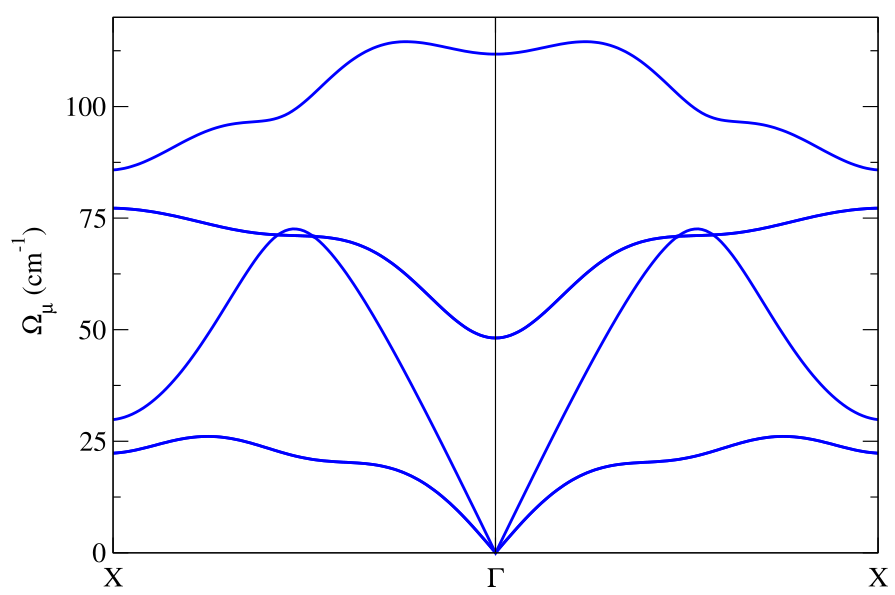

Notice in this plot the LO-TO splitting, which is calculated by the SSHCA code using the effective charges and the electronic permittivity tensor printed in the center zone dynamical matrix file (Sec. 3.8 ).

The static calculation is essentially devoted to identify the presence of structural instabilities (in this case, as we can see, we do not have instabilities along $\Gamma-X$).
To properly compute the phonon spectrum a dynamical calculation has to be performed. As a first thing, let us do a double-check calculation. Let us compute the spectral function $\sigma(\Omega)$ in $X$ and $\Gamma$ obtained in the static approximation Eqs.(35),(36),(84). The resulting spectral function must be composed of peaks around the Hessian frequencies.

In [ ]:
import cellconstructor as CC
import cellconstructor.ForceTensor
import cellconstructor.Structure
import cellconstructor.Spectral

dyn = CC.Phonons.Phonons("PbTe.SSCHA.dyn",8)

supercell = dyn.GetSupercell()
tensor3 = CC.ForceTensor.Tensor3(dyn.structure,
                                dyn.structure.generate_supercell(supercell),
                                supercell)

tensor3.SetupFromFile(fname="FC3",file_format='D3Q')


# integration grid
k_grid=[20,20,20]    

# X and G in 2pi/Angstrom
points=[[-0.1525326,  0.0,  0.0],
        [0.0       ,  0.0,  0.0]      ]

CC.Spectral.get_full_dynamic_correction_along_path(dyn=dyn, 
                                                   tensor3=tensor3, 
                                                   k_grid=k_grid,  
                                                   e1=100, de=0.1, e0=0,
                                                   sm1=1.0, sm0=1.0, 
                                                   sm1_id=0.1, sm0_id=0.1,
                                                   nsm=1,
                                                   T=300,
                                                   q_path=points,                                                                                     
                                                   static_limit = True, 
                                                   notransl = True,  # projects out the acoustic zone center modes
                                                   filename_sp='static_spectral_func')

We decided to project out the part of the spectral function due to the pure translation modes (since they convey
a trivial information). The result is in the *"static_spectral_func_0.1_1.0.dat"* file. 
The first column is the distance of the followed reciprocal space path in $2\pi$/Å (an information that we are not going to use now). For each point we have the values $\Omega$ of the used energy grid (second column) and the spectral function $\sigma(\Omega)$ ( third column).

Here we plot $\sigma(\Omega)$ for the two points with black line. The colored vertical lines are the Hessian frequency values previosuly calculated in $X$ and $\Gamma$. Note that the higher peaks correspond to double degenerate frequencies.

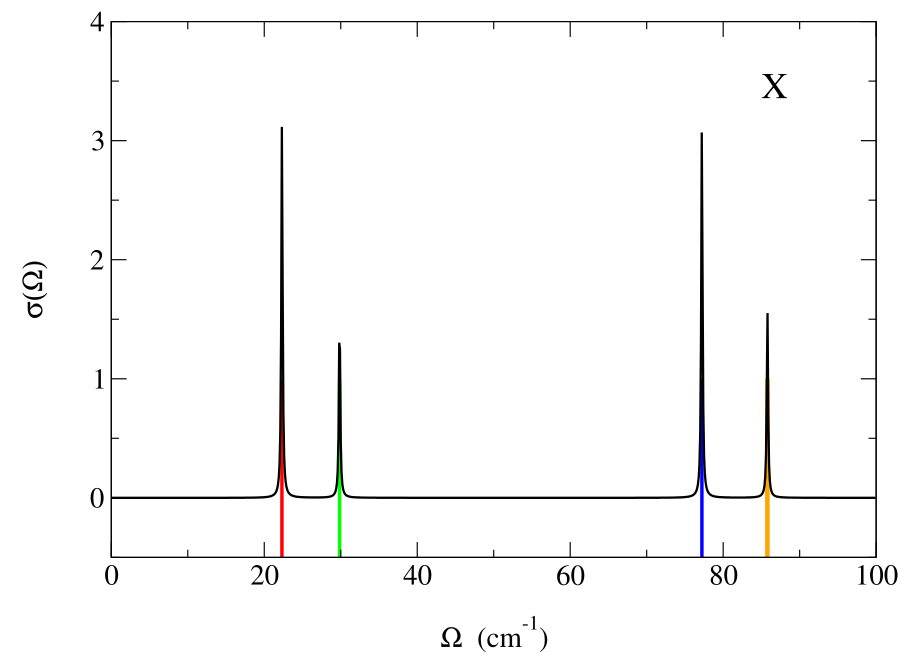

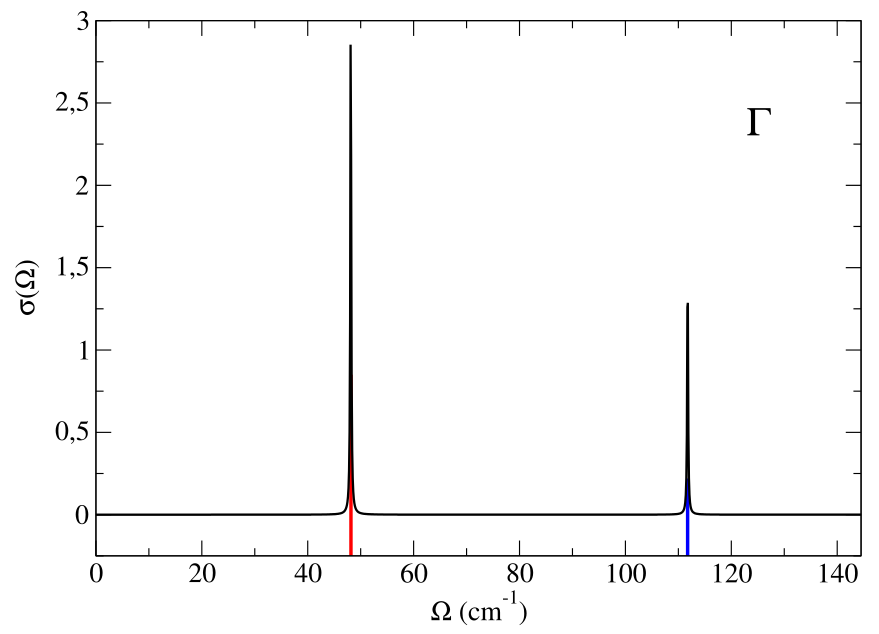

Now we perform a full spectral calculation in $\Gamma$, Eq. (39), with the input

In [ ]:
import cellconstructor as CC
import cellconstructor.ForceTensor
import cellconstructor.Structure
import cellconstructor.Spectral

dyn = CC.Phonons.Phonons("PbTe.SSCHA.dyn",8)

supercell = dyn.GetSupercell()
tensor3 = CC.ForceTensor.Tensor3(dyn.structure,
                                dyn.structure.generate_supercell(supercell),
                                supercell)

tensor3.SetupFromFile(fname="FC3",file_format='D3Q')


# integration grid
k_grid=[20,20,20]    

# q point
G=[0.0,0.0,0.0]


CC.Spectral.get_full_dynamic_correction_along_path(dyn=dyn, 
                                           tensor3=tensor3, 
                                           k_grid=k_grid,  
                                           e1=145, de=0.1, e0=0,
                                           sm1=1, sm0=1, 
                                           sm1_id=0.1, sm0_id=0.1,
                                           nsm=1,
                                           T=300,
                                           q_path=G,                                           
                                           notransl = True,
                                           filename_sp='full_spectral_func')


and plot the result (second and third column of the *"full_spectral_func_0.1_1.0.dat"* file). 

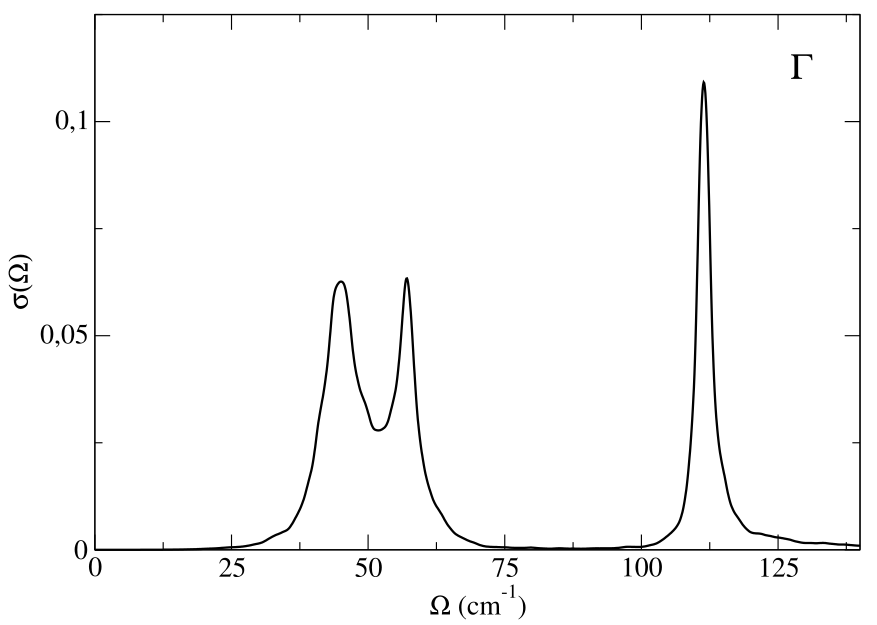

In this calculation we have calculated the full self-energy. We can also employ the no-mode-mixing approximation, 
Eqs. (40-42), discarding the off-diagonal elements of the  self-energy in the SSCHA mode basis set with the input 

In [ ]:
from __future__ import print_function
import cellconstructor as CC
import cellconstructor.ForceTensor
import cellconstructor.Structure
import cellconstructor.Spectral

dyn = CC.Phonons.Phonons("PbTe.SSCHA.dyn",8)

supercell = dyn.GetSupercell()
tensor3 = CC.ForceTensor.Tensor3(dyn.structure,
                                dyn.structure.generate_supercell(supercell),
                                supercell)

tensor3.SetupFromFile(fname="FC3",file_format='D3Q')


# integration grid
k_grid=[20,20,20]    

# 
G=[0.0,0.0,0.0]

CC.Spectral.get_diag_dynamic_correction_along_path(dyn=dyn, 
                                                   tensor3=tensor3,  
                                                   k_grid=k_grid, 
                                                   q_path=G,
                                                   T = 300.0, 
                                                   e1=145, de=0.1, e0=0,
                                                   sm1=1.0, nsm=1, sm0=1.0,
                                                   sm1_id=0.1, sm0_id=0.1
                                                   filename_sp = 'nomm_spectral_func')


The result is printed in the *"nomm_spectral_func_0.1_1.0.dat"* file. As before, the first column gives the distance along the path in reciprocal space (here inessential, we are doing a single point calculation), the second column the energy grid values, the third column the spectral function, and subsequently a column for each single mode contribution to the spectral function. Here we are interested in the modes 4,5,6 (the first three modes are the acoustic ones).

If we consider the sum of the spectral function of these three modes we essentially obtain the same result obtined with the full self-energy calculation. Therefore, we can safely use the no-mode-mixing approximation.
We can perform a spectral analysis mode by mode: 

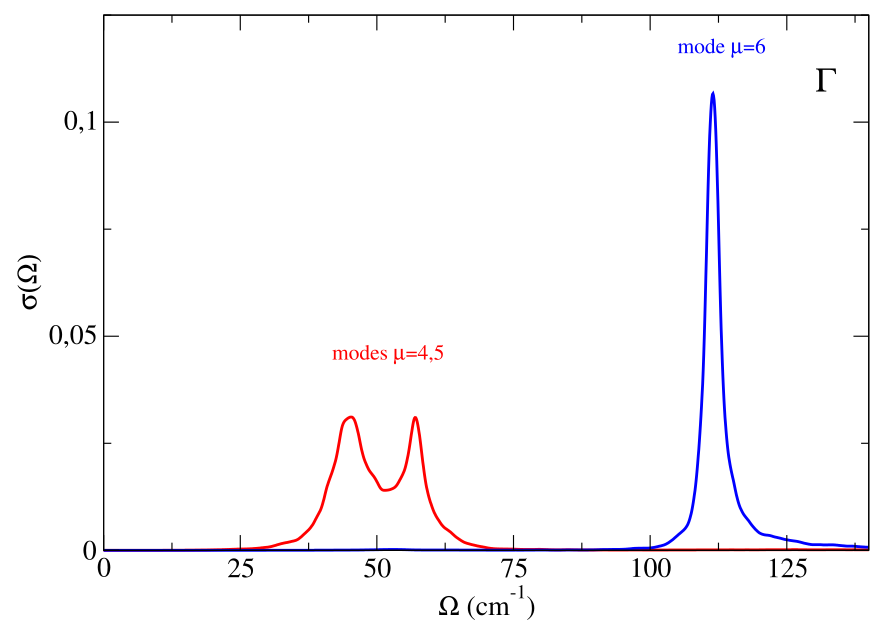

The modes 4 and 5 are degenerate (their sum gives the corresponding part of the spectral function showed in the previous figure).  As it is evident, while the mode 6 seems to have a Lorentzian character (with precise
center and linewidth), for the modes 4 and 5 there is a clear no-Lorentzian character. This is evident if we plot the Lorentzian spectral functions for these modes, using for example the "one-shot" approach, Eqs. (43), (46), (47), that we find in the file *"nomm_spectral_func_lorentz_one_shot_0.1_1.0.dat"*.
As we can see, the spectral function for the mode 6 is well described in the Lorentzian approximation, whereas modes 4 and 5 have a strong non-Lorentzian character.

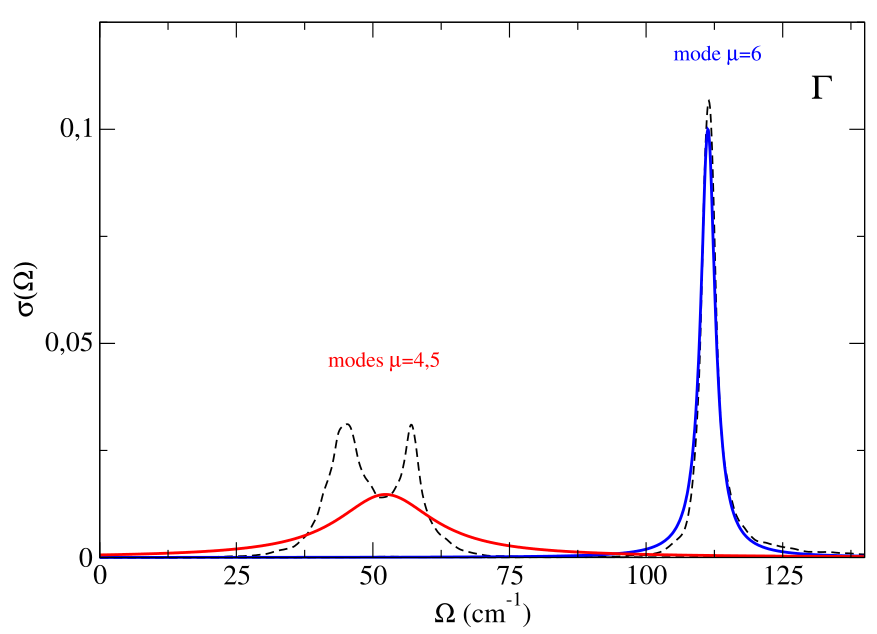

To have a more complete picture we can compute the spectral function (in no-mode-mixing approximation)
along the $X-G-X$ path.

In [ ]:
from __future__ import print_function
import cellconstructor as CC
import cellconstructor.ForceTensor
import cellconstructor.Structure
import cellconstructor.Spectral

dyn = CC.Phonons.Phonons("PbTe.SSCHA.dyn",8)

supercell = dyn.GetSupercell()
tensor3 = CC.ForceTensor.Tensor3(dyn.structure,
                                dyn.structure.generate_supercell(supercell),
                                supercell)

tensor3.SetupFromFile(fname="FC3",file_format='D3Q')


# integration grid
k_grid=[20,20,20]    

CC.Spectral.get_diag_dynamic_correction_along_path(dyn=dyn, 
                                                   tensor3=tensor3,  
                                                   k_grid=k_grid, 
                                                   q_path_file="XGX_path.dat"
                                                   T = 300.0, 
                                                   e1=145, de=0.1, e0=0,
                                                   sm1=1.0, nsm=1, sm0=1.0,
                                                   sm1_id=0.1, sm0_id=0.1
                                                   filename_sp = 'nomm_spectral_func')

We plot the first three columns of *"nomm_spectral_func_0.1_1.0.dat"* with a colormap plot (the spectral function plotted as a color function)

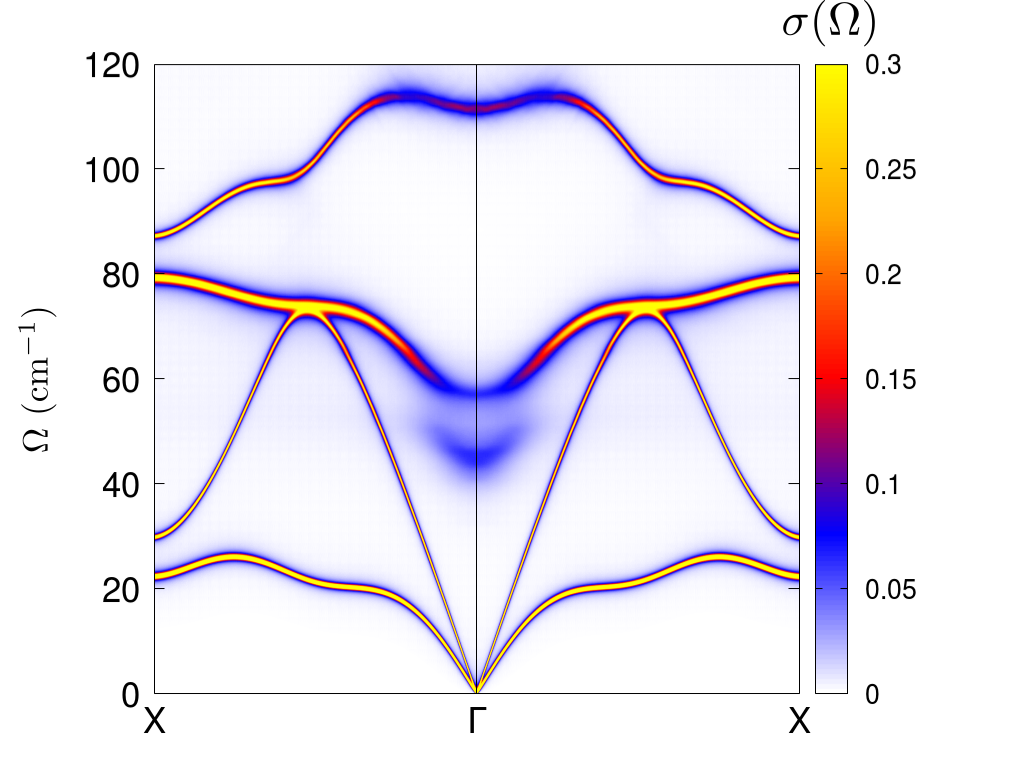

We clearly see a satellite in $\Gamma$, which well reproduces what is seen in experiments ([Ribeiro et al.,Phys. Rev. B 97, 014306](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.97.014306)).